In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
mp_key = "KcpGNlNwBWUwWN6pcJS1SzDUsDUsCA2z"
mp_id = "mp-2286"

In [3]:
with MPRester(mp_key) as m:
    el_bs = m.get_bandstructure_by_material_id(mp_id)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from matplotlib import pyplot as plt 
from tabulate import tabulate

In [8]:
bandgap = el_bs.get_band_gap()

In [9]:
# valeur de la bande interdite en eV
print(bandgap.get("energy"))

2.9746


In [10]:
# numéros des bandes contenant les vbm et cbm
i_vbm = list(el_bs.get_vbm()['band_index'].values())[-1][-1]
i_cbm = list(el_bs.get_cbm()['band_index'].values())[-1][0]
print("VBM:", i_vbm, "CBM:", i_cbm)

VBM: 5 CBM: 6


In [11]:
plot = BSPlotter(el_bs)
data = plot.bs_plot_data()
distances = data.get('distances')
energy = data.get('energy')

In [12]:
# calcule la pente sur l'intervalle (x, y)
# return un tableau pour chaque intervalle de kpoints de la forme: [pente, x_0, y_0, dx, dy]
def slope(x,y):
    return np.array([abs((y[-1]-y[0])/(x[-1]-x[0])),x[0],y[0],x[-1]-x[0],y[-1]-y[0]])

In [13]:
# calcule la dispersion maximale et minimale de la bande y
# return: un tableau des slopes pour chaque intervalle de kpoints, l'indice de la pente maximale, l'indice de la pente minimale
def computeDispersions(y):
    slopes = np.zeros((len(distances),5))
    for i in range(len(slopes)):
        slopes[i] = slope(distances[i],energy.get('1')[i][y])
    s = (slopes.T)
    return (s,np.argmax(s[0]),np.argmin(s[0]))

In [14]:
(cbs,maxCb,minCb) = computeDispersions(6)
(vbs,maxVb,minVb) = computeDispersions(5)

In [15]:
distance = data.get("ticks").get("distance")
vbm = data.get("vbm")
cbm = data.get("cbm")

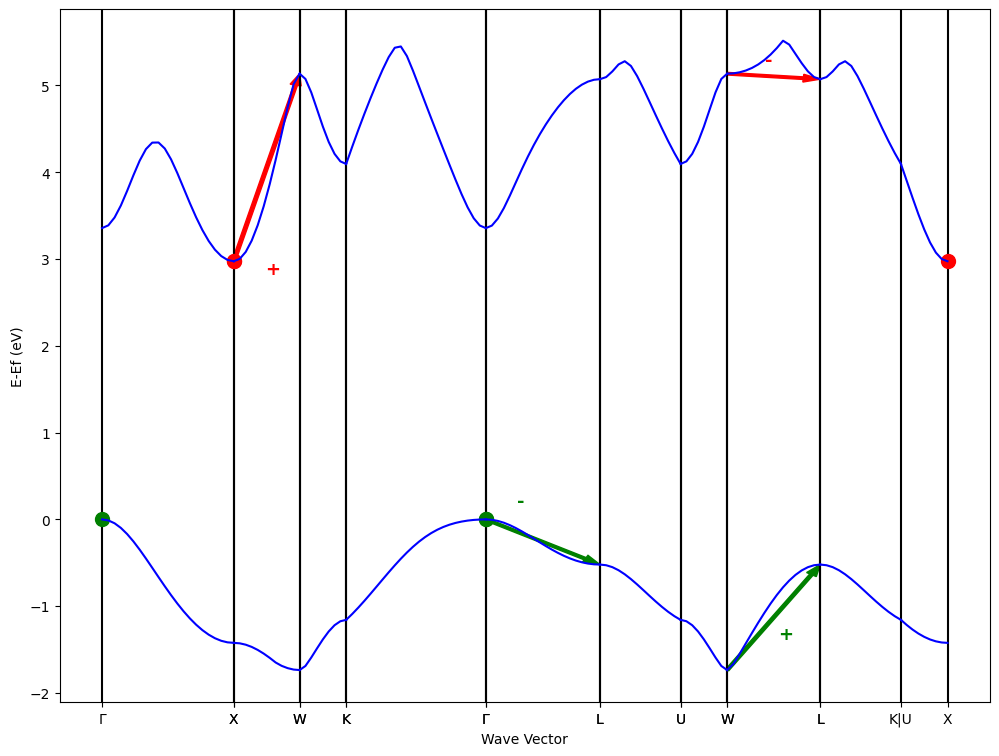

In [16]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
for i in range(len(distance)):
    plt.axvline(distance[i],0,color="black")
    
for i in range(len(vbm)):
    (a,b) = vbm[i]
    plt.plot(a,b,'og',markersize=10)
for i in range(len(cbm)):
    (a,b) = cbm[i]
    plt.plot(a,b,'or',markersize=10)
    
for i in range(len(distances)):
    plt.plot(distances[i],energy.get('1')[i][5],'b')
    plt.plot(distances[i],energy.get('1')[i][6],'b')
    
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393', "", 'X', "", 'W', "", 'K', "", '\u0393', "", 'L', "", 'U', "", 'W', "", 'L', 'K|U', 'X'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')

plt.arrow(cbs[1,maxCb],cbs[2,maxCb],cbs[3,maxCb],cbs[4,maxCb],color='red',width=0.03,length_includes_head=True)
plt.arrow(cbs[1,minCb],cbs[2,minCb],cbs[3,minCb],cbs[4,minCb],color='red',width=0.03,length_includes_head=True)
plt.arrow(vbs[1,maxVb],vbs[2,maxVb],vbs[3,maxVb],vbs[4,maxVb],color='green',width=0.03,length_includes_head=True)
plt.arrow(vbs[1,minVb],vbs[2,minVb],vbs[3,minVb],vbs[4,minVb],color='green',width=0.03,length_includes_head=True)

plt.text(cbs[1,maxCb]+0.25,cbs[2,maxCb]-0.15,"+",fontsize=13,fontweight='bold',color='red')
plt.text(cbs[1,minCb]+0.3,cbs[2,minCb]+0.1,"-",fontsize=13,fontweight='bold',color='red')
plt.text(vbs[1,maxVb]+0.4,vbs[2,maxVb]+0.35,"+",fontsize=13,fontweight='bold',color='green')
plt.text(vbs[1,minVb]+0.25,vbs[2,minVb]+0.15,"-",fontsize=13,fontweight='bold',color='green')

plt.show()

In [17]:
# La dernière bande de valence présente donc le plus de dispersion dans la direction  W-L
# et le moins de dispersion dans la direction Γ-L
# La première bande de conduction présente donc le plus de dispersion dans la direction  X-W
# et le moins de dispersion dans la direction W-L

In [22]:
hbar2 = ((6.62607004*10**(-34))/(2*np.pi))**2
electronvolt = 1.602176634*10**(-19)
angstrom = 10**(-10) 
print(data.get("distances"))

[array([0.        , 0.04970277, 0.09940556, 0.14910834, 0.19881113,
       0.2485139 , 0.29821667, 0.34791946, 0.39762223, 0.44732501,
       0.4970278 , 0.54673057, 0.59643336, 0.64613613, 0.6958389 ,
       0.7455417 , 0.79524447, 0.84494724, 0.89465003, 0.9443528 ,
       0.9940556 , 1.04375837]), array([1.04375837, 1.09120192, 1.1386455 , 1.18608906, 1.23353261,
       1.28097617, 1.32841975, 1.3758633 , 1.42330686, 1.47075042,
       1.51819399, 1.56563755]), array([1.56563755, 1.61176559, 1.65789363, 1.70402167, 1.75014971,
       1.79627774, 1.84240578, 1.88853382, 1.93466186]), array([1.93466186, 1.98279547, 2.03092907, 2.07906268, 2.12719628,
       2.17532989, 2.22346349, 2.2715971 , 2.31973071, 2.36786431,
       2.41599792, 2.46413152, 2.51226513, 2.56039873, 2.60853234,
       2.65666594, 2.70479955, 2.75293316, 2.80106676, 2.84920037,
       2.89733397, 2.94546758, 2.99360118, 3.04173479]), array([3.04173479, 3.08930959, 3.1368844 , 3.1844592 , 3.23203401,
       3.279608

In [23]:
# calcul de la parabole d'approximation aux alentours du VBM
ks = np.zeros(3)
es = np.zeros(3)
(ks[1],es[1]) = vbm[1]
(ks[0],es[0]) = (distances[3][-2],energy.get('1')[3][5][-2])
(ks[2],es[2]) = (distances[4][2],energy.get('1')[4][5][2])
a = np.polyfit(ks,es,2)

In [24]:
# calcul de la masse effective au sommet de la dernière bande de valence en kg
print(hbar2/(2*a[0]*electronvolt*(angstrom)**2))

-2.3234117789584634e-30


In [27]:
# calcul de la parabole d'approximation aux alentours du CBM
ks2 = np.zeros(3)
es2 = np.zeros(3)
(ks2[1],es2[1]) = cbm[1]
(ks2[0],es2[0]) = (distances[0][-2],energy.get('1')[0][6][-2])
(ks2[2],es2[2]) = (distances[1][2],energy.get('1')[1][6][2])
a2 = np.polyfit(ks2,es2,2)

In [28]:
# calcul de la masse effective à la base de la première bande de conduction en kg
print(hbar2/(2*a2[0]*electronvolt*(angstrom)**2))

3.502850061228116e-31
